In [ ]:
# !git clone --recurse-submodules https://github.com/mikel-brostrom/Yolov5_StrongSORT_OSNet.git

In [3]:
#colabの./data/video/ファイルに解析したい動画を設置
!python track.py --source ./data/video/attention.mp4 --yolo-weights yolov5/weights/crowdhuman_yolov5m.pt --strong-sort-weights osnet_x0_25_imagenet.pt --classes 0  --save-vid --save-txt # tracks persons, only
# !python track.py --source ./data/video/toyota_lineworker1.mp4 --strong-sort-weights yolov5/weights/osnet_ibn_x1_0_market1501_256x128_amsgrad_ep150_stp60_lr0.0015_b64_fb10_softmax_labelsmooth_flip_jitter.pth --classes 0  --save-vid --save-txt # tracks persons, only

ストリーミング出力は最後の 5000 行に切り捨てられました。
video 1/1 (51368/56364) /content/drive/MyDrive/ColabNotebooks/yolo/Yolov5_StrongSORT_OSNet/data/video/attention.mp4: 384x640 2 persons, Done. YOLO:(0.022s), StrongSORT:(0.025s)
video 1/1 (51369/56364) /content/drive/MyDrive/ColabNotebooks/yolo/Yolov5_StrongSORT_OSNet/data/video/attention.mp4: 384x640 2 persons, Done. YOLO:(0.022s), StrongSORT:(0.026s)
video 1/1 (51370/56364) /content/drive/MyDrive/ColabNotebooks/yolo/Yolov5_StrongSORT_OSNet/data/video/attention.mp4: 384x640 2 persons, Done. YOLO:(0.024s), StrongSORT:(0.027s)
video 1/1 (51371/56364) /content/drive/MyDrive/ColabNotebooks/yolo/Yolov5_StrongSORT_OSNet/data/video/attention.mp4: 384x640 2 persons, Done. YOLO:(0.022s), StrongSORT:(0.026s)
video 1/1 (51372/56364) /content/drive/MyDrive/ColabNotebooks/yolo/Yolov5_StrongSORT_OSNet/data/video/attention.mp4: 384x640 2 persons, Done. YOLO:(0.022s), StrongSORT:(0.025s)
video 1/1 (51373/56364) /content/drive/MyDrive/ColabNotebooks/yolo/Yolov5_StrongSOR

In [ ]:
# !wget -nc https://github.com/mikel-brostrom/Yolov5_StrongSORT_OSNet/releases/download/v.2.0/crowdhuman_yolov5m.pt -O /content/drive/MyDrive/Colab Notebooks/yolo/Yolov5_StrongSORT_OSNet/yolov5/weights/crowdhuman_yolov5m.pt

In [1]:
#colabからマウント
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/ColabNotebooks/yolo/Yolov5_StrongSORT_OSNet
!pip install -r requirements.txt

/content/drive/MyDrive/ColabNotebooks/yolo/Yolov5_StrongSORT_OSNet
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.0 MB 31.5 MB/s 
     |████████████████████████████████| 61 kB 539 kB/s 
     |████████████████████████████████| 190 kB 63.4 MB/s 
     |████████████████████████████████| 42 kB 1.2 MB/s 
     |████████████████████████████████| 182 kB 65.7 MB/s 
     |████████████████████████████████| 41 kB 452 kB/s 
     |████████████████████████████████| 66 kB 4.8 MB/s 
     |████████████████████████████████| 61 kB 519 kB/s 
     |████████████████████████████████| 61 kB 570 kB/s 
     |████████████████████████████████| 61 kB 377 kB/s 
     |████████████████████████████████| 61 kB 286 kB/s 
     |████████████████████████████████| 64 kB 3.2 MB/s 
     |████████████████████████████████| 64 kB 3.3 MB/s 
     |████████████████████████████████| 73 kB 2.1 MB/s 
     |████████████████████████████████| 68 k

In [ ]:
#流線グラフ作成セクション
import pandas as pd
from tqdm import tqdm
import time
import numpy as np
from sklearn.cluster import KMeans
import random
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.collections import LineCollection
!pip install openpyxl
!pip install xlwt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#解析した動画のバウンディングボックス座標が入ったテキストファイルをDataFrameに格納
data_list = []
temp = []
#解析した動画名を入れる([exp*, 動画名])
filename = ['','usually']
#解析した動画が入っているファイル名に変更
filepath = '/exp2'+ filename[0] +'/tracks/' + filename[1] + '.txt' 
with open('/content/drive/MyDrive/ColabNotebooks/yolo/Yolov5_StrongSORT_OSNet/runs/track' + filepath, 'r') as f:
  for data in f:
    line = data.strip()
    str_list = line.split(' ')
    num_list = [int(s) for s in str_list]
    data_list.append(num_list)
nparray = np.array(data_list, dtype=float)
df = pd.DataFrame({
    'time': nparray[ : , 0 ],
    'trackingNo': nparray[ : , 1 ],
    'x': nparray[ : , 2 ],
    'y': nparray[ : , 3 ],
    'width': nparray[ : , 4 ],
    'height': nparray[ : , 5 ],
})
#動画のサイズを入力
x_width = 1280
y_width = 720
#データの加工
 #中心座標計算
df["x_center"] = df["x"] + (df["width"]/2);
df["y_center"] = df["y"] + (df["height"]/2);

#後ほど動画検出で使う配列
detect_df = df.loc[:, ['time', 'trackingNo', 'x_center', 'y_center']];
target_1 = detect_df.index[detect_df['x_center'] <= 320]
detect_df_frame_1 = detect_df.drop(target_1)
target_2 = detect_df_frame_1.index[detect_df_frame_1['x_center'] >= 650]
detect_df_frame_2 = detect_df_frame_1.drop(target_2)
detect_nparray = detect_df_frame_2.values

 #正規化
df["x_normalized"] = df["x_center"] / x_width;
df["y_normalized"] = df["y_center"] / y_width;
  #nparrayに戻す
new_df = df.loc[:, ['time', 'trackingNo', 'x_normalized', 'y_normalized']];
new_nparray = new_df.values



In [ ]:
df.to_excel('/content/drive/MyDrive/'+filename[1]+'.xlsx', index=False, header=True)

In [ ]:
# 解析したい人はバウンディングボックスの何番目か？(人数によって追加)

person_1 = []
# person_2 = []
for item in new_nparray:
  if (item[1]==1 or item[1]==358):
    person_1.append(item)

#usually
#item[1]==1 or item[1]==358
#loss 
#item[1]==1 or item[1]==22 or item[1]==29 or item[1]==34 or item[1]==44 or item[1]==76 or item[1]==241 or item[1]==384 or item[1]==494
#attention(0:00 - 10:25)
# item[1]==1 or item[1]==15 or item[1]==18 or item[1]==22 or item[1]==23 or item[1]==25 or item[1]==31 or item[1]==35 or item[1]==37
#       or item[1]==49 or item[1]==51 or item[1]==53 or item[1]==60 or item[1]==63 or item[1]==96 or item[1]==102or item[1]==103 or item[1]==137 
#       or item[1]==141 or item[1]==142or item[1]==173 or item[1]==179 or item[1]==182 or item[1]==223 or item[1]==230 or item[1]==330
#       or item[1]==334 or item[1]==335 or item[1]==365 or item[1]==370 or item[1]==372 or item[1]==418




  # elif item[1]==2 or item[1]==4 or item[1]==19 or item[1]==47:
  #   person_2.append(item)
person_1 = np.array(person_1)
# person_2 = np.array(person_2)


In [ ]:
# 解析したい人の配列長さを確認
print(person_1.shape)

#xy座標だけを取り出す
input_data_xy = [] 
#解析したい人のxy座標をリストにする
for item in person_1:
  input_data_xy.append([item[2], item[3]])

print(input_data_xy)

(6153, 4)
[[0.465625, 0.6694444444444444], [0.468359375, 0.6701388888888888], [0.4625, 0.6694444444444444], [0.460546875, 0.6680555555555555], [0.459765625, 0.6673611111111111], [0.459765625, 0.6673611111111111], [0.46015625, 0.6673611111111111], [0.469921875, 0.6701388888888888], [0.466796875, 0.6673611111111111], [0.45859375, 0.6638888888888889], [0.466015625, 0.6659722222222222], [0.451953125, 0.6631944444444444], [0.4515625, 0.6631944444444444], [0.445703125, 0.6618055555555555], [0.444921875, 0.6631944444444444], [0.44296875, 0.6631944444444444], [0.44140625, 0.6645833333333333], [0.437890625, 0.6659722222222222], [0.4359375, 0.6666666666666666], [0.433984375, 0.66875], [0.432421875, 0.6694444444444444], [0.43125, 0.6694444444444444], [0.43125, 0.6694444444444444], [0.43203125, 0.66875], [0.431640625, 0.66875], [0.43125, 0.66875], [0.430859375, 0.66875], [0.4296875, 0.66875], [0.42890625, 0.6694444444444444], [0.428515625, 0.6694444444444444], [0.422265625, 0.6694444444444444], [0

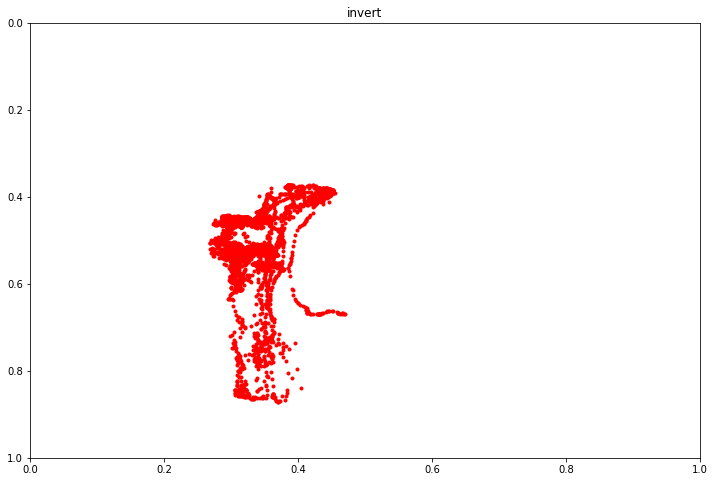

In [ ]:
#グラフ描写 ( 逆転前（コメントアウト）)
# fig, (plot1,plot2) =plt.subplots(2,1)
# for item in new_nparray:
#   if item[1]==1:
#     plot1.plot(item[2],item[3],marker='.',color='red')
#   elif item[1]==2 or item[1]==41:
#     plot1.plot(item[2],item[3],marker='.',color='blue')
# plot1.set_title("original")
# plot1.set_xlim(0,1)
# plot1.set_ylim(0.6,0.9)

#グラフ描写 ( 逆転後 ) : 画像のy軸は上から下に通っているため、反転させる
i, j = 0, 0
fig, plot2 =plt.subplots(figsize=(12, 8))

for item in input_data_xy:
    plot2.plot(item[0],item[1],marker='.',color='red')
  # elif item[1]==2 or item[1]==41:
  #   plot2.plot(item[2],item[3],marker='.',color='blue')
    
plot2.set_title("invert")
plot2.set_xlim(0,1)
plot2.set_ylim(0,1)
plot2.invert_yaxis()

plt.show()

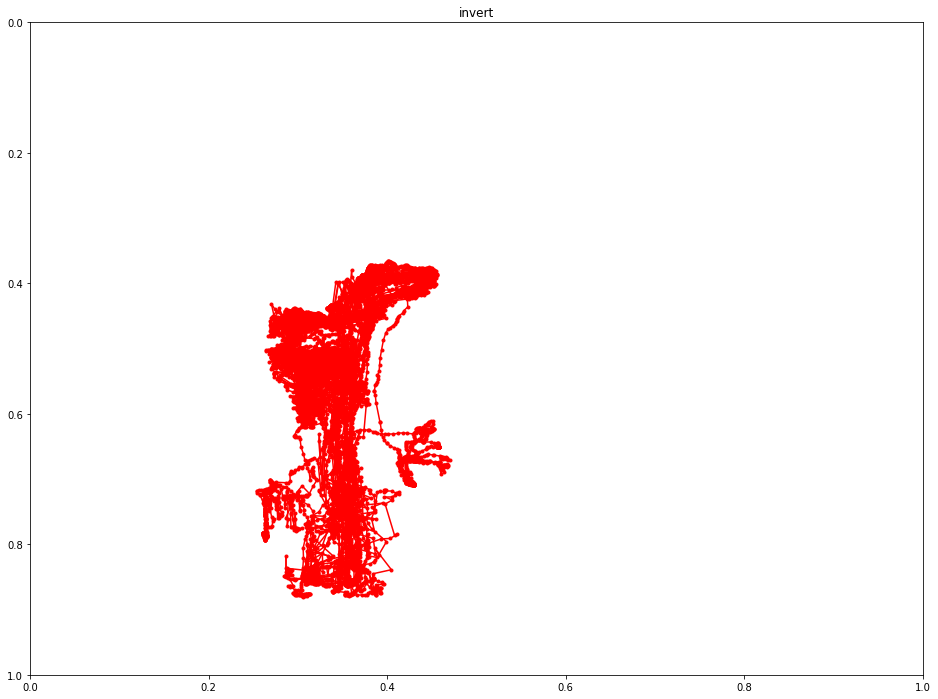

In [ ]:
#矢印で流線を作る: 最後のインデックスが存在しない
lines = []
i, j = 0, 0
fig, plot2 =plt.subplots(figsize=(16, 12))

for item in input_data_xy:
    plot2.plot(item[0],item[1],marker='.',color='red')
  # elif item[1]==2 or item[1]==41:
  #   plot2.plot(item[2],item[3],marker='.',color='blue')

arrow_dict_red = dict(arrowstyle="->", connectionstyle="arc", color="red")
# arrow_dict_blue = dict(arrowstyle="->", connectionstyle="arc", color="blue")
    
for item in input_data_xy:
  if i!=(len(input_data_xy) - 1):
    # plot2.annotate("", xy = (person_1[i+1, 2], person_1[i+1, 3]), size = 15, xytext = (person_1[i, 2], person_1[i, 3]),
    #         color = "red", arrowprops = arrow_dict_red)
    lines.append( [ [person_1[i, 2], person_1[i, 3]], [person_1[i+1, 2], person_1[i+1, 3]] ] )
    i+=1

  # elif (item[1]==2 or item[1]==41) and j!=1216:
  #   plot2.annotate("", xy = (person_2[j+1, 2], person_2[j+1, 3]), size = 15, xytext = (person_2[j, 2], person_2[j, 3]),
  #           color = "blue", arrowprops = arrow_dict_blue)
  #   j+=1

lc = LineCollection(lines, colors="r")

plot2.set_title("invert")
plot2.set_xlim(0,1)
plot2.set_ylim(0,1)
plot2.invert_yaxis()
plot2.add_collection(lc)

plt.show()

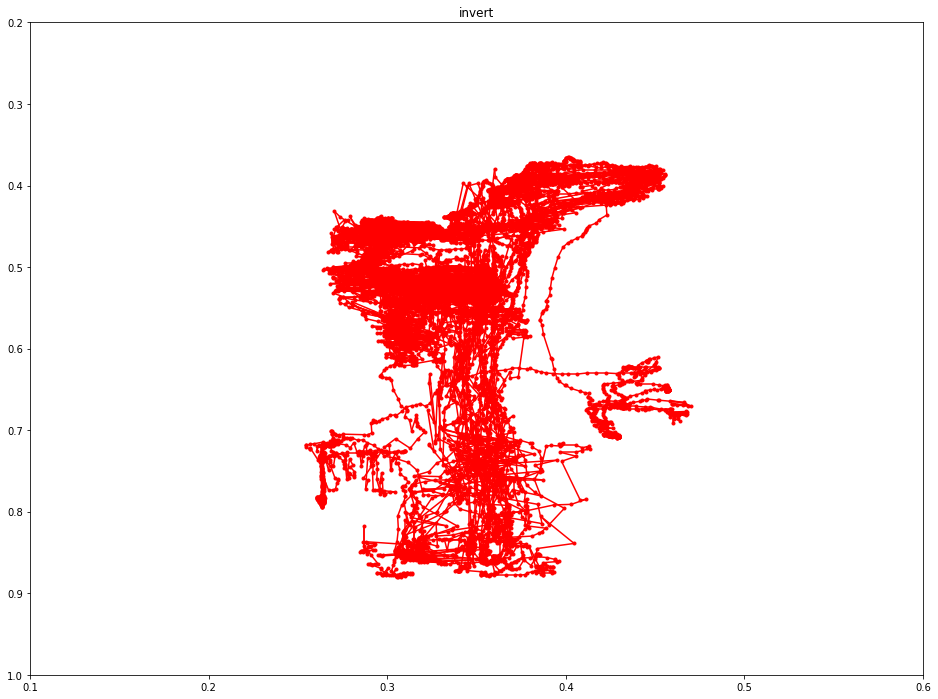

In [ ]:
#矢印で流線を作る: plot2.set_*lim で拡大縮小
lines = []
i, j = 0, 0
fig, plot2 =plt.subplots(figsize=(16, 12))

for item in input_data_xy:
    plot2.plot(item[0],item[1],marker='.',color='red')
  # elif item[1]==2 or item[1]==41:
  #   plot2.plot(item[2],item[3],marker='.',color='blue')

arrow_dict_red = dict(arrowstyle="->", connectionstyle="arc", color="red")
# arrow_dict_blue = dict(arrowstyle="->", connectionstyle="arc", color="blue")
    
for item in input_data_xy:
  if i!=(len(input_data_xy) - 1):
    # plot2.annotate("", xy = (person_1[i+1, 2], person_1[i+1, 3]), size = 15, xytext = (person_1[i, 2], person_1[i, 3]),
    #         color = "red", arrowprops = arrow_dict_red)
    lines.append( [ [person_1[i, 2], person_1[i, 3]], [person_1[i+1, 2], person_1[i+1, 3]] ] )
    i+=1

  # elif (item[1]==2 or item[1]==41) and j!=1216:
  #   plot2.annotate("", xy = (person_2[j+1, 2], person_2[j+1, 3]), size = 15, xytext = (person_2[j, 2], person_2[j, 3]),
  #           color = "blue", arrowprops = arrow_dict_blue)
  #   j+=1

lc = LineCollection(lines, colors="r")

plot2.set_title("invert")
plot2.set_xlim(0.1,0.6)
plot2.set_ylim(0.2,1)
plot2.invert_yaxis()
plot2.add_collection(lc)

plt.show()


{0: '#ff0000', 1: '#1900ff', 2: '#00ff2a'}


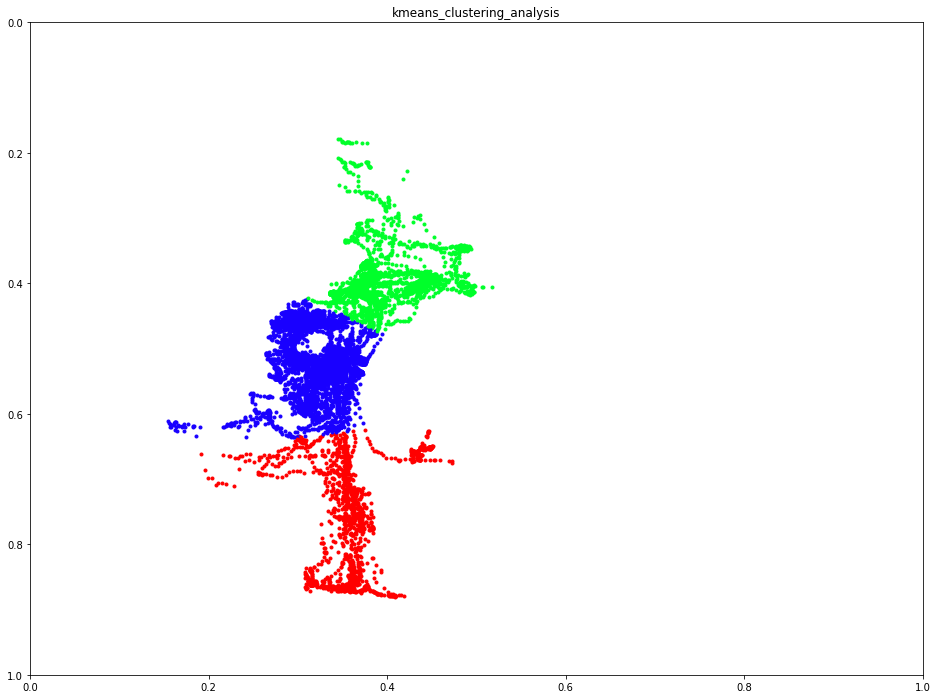

In [ ]:
#クラスタリング(クラスター数を決める)
cluster_num = 3

#k-means
km = KMeans(n_clusters=cluster_num, random_state=10).fit(input_data_xy) # クラスタリングの計算を実行する
kmeans_model = km.fit_predict(input_data_xy) # 各サンプルに対するクラスタ番号を求める

#カラー生成
keys=list(range(cluster_num))
values = ['#ff0000','#1900ff','#00ff2a','#00f7ff', '#000000']  # 赤　青　みどり　水色 黒
color_codes = dict(zip(keys, values))

print(color_codes)

#plot
fig, ax = plt.subplots(figsize=(16, 12))
for label, feature in zip(kmeans_model, input_data_xy): #input_data_xyの各要素に対するkmeans_modelはクラスタ番号
  plt.plot(feature[0], feature[1], marker='.', color=color_codes[label])

ax.set_title("kmeans_clustering_analysis")
ax.set_xlim(0, 1)
ax.set_ylim(0 ,1)
ax.invert_yaxis()
plt.show()

In [ ]:
#k-meansのクラスタ番号を配列に追加
person_label = []
for label, person_data in zip(kmeans_model, person_1):
  if label == 2:
    label = 0
  elif label == 1:
    label = 2
  else:
    label = 1

  person_label.append(np.append(person_data, label))

print(len(person_label))

15210


In [ ]:
!pip install openpyxl
!pip install statistics
import math
import openpyxl
import pprint

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for statistics: filename=statistics-1.0.3.5-py3-none-any.whl size=7454 sha256=2352327fab540c9bc4b7d8305bc7f25da84d418c225b70b1558e7e7915f7c4d1
  Stored in directory: /root/.cache/pip/wheels/37/09/e1/49ee45c0ce248a6e9c986aae82d32bbcba09c9f3b9d0c3406a
Successfully built statistics


In [ ]:
#yoloの出力txtファイル設定(動画の秒数/ｔｘｔファイルのステップ数)
movie_time = "10:19"
movie_step = person_1[len(person_1) - 1][0] - person_1[0][0]
movie_sec = int(movie_time[:-3])*60 +int(movie_time[-2:])
onestep_time = float(movie_sec/movie_step)
#動画の切り抜きたいステップ（１サイクル）
start_time = "0:00"
end_time = "10:19"
start_time_sec = int(start_time[:-3])*60 +int(start_time[-2:])
end_time_sec = int(end_time[:-3])*60 +int(end_time[-2:])
start_step = math.floor(start_time_sec / onestep_time) + person_1[0][0]
end_step = math.ceil((end_time_sec - start_time_sec) / onestep_time) + person_1[0][0]
cut_step = int(end_step - start_step)

#切り抜きたい範囲の座標とクラスタ番号を配列にする
onecycle_data = []
temp_data = []
for item in person_label:
  if ( item[0] >= start_step ) & ( item[0] <= end_step ):
    onecycle_data.append(item[2:5])
    temp_data.append(item[0:5])

#1秒ごとにデータを切り出す
excel_graphdata = []
flag = False
graph_num = cut_step
for i in range(cut_step):
  if i % 30 ==0:
    for j in range(len(temp_data)):
      if (temp_data[j][0] == i):
        excel_graphdata.append(onecycle_data[j])
        flag = True
    if (not(flag)):
      excel_graphdata.append([0, 0, -1])
    flag = False

In [ ]:
print(len(excel_graphdata))
print(end_time_sec - start_time_sec)
print(1/onestep_time)

619
619
29.993537964458802


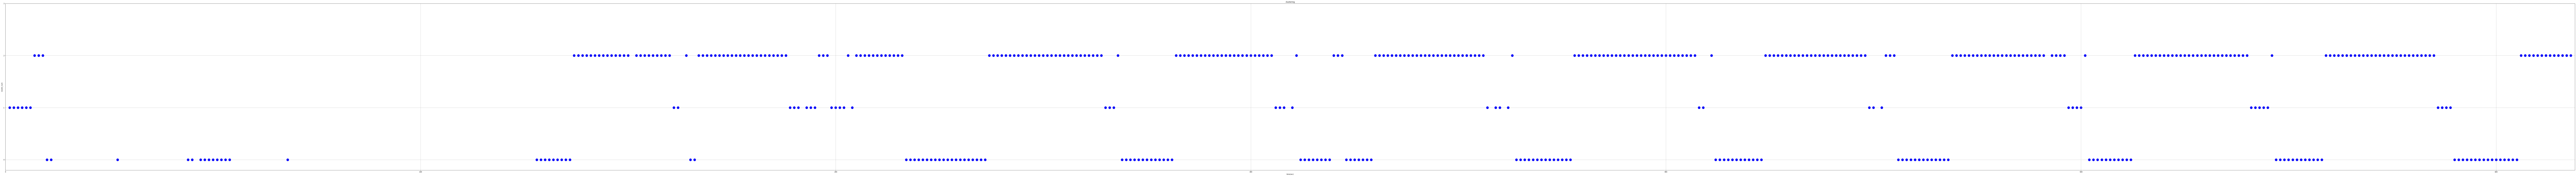

In [ ]:
#配列宣言
sec = range(len(excel_graphdata))
#pythonグラフ作成セクション
plt.figure(figsize=(300,20))
plt.xlim(0, movie_sec) #x軸の表示範囲
plt.ylim(-0.2, 2.2) #y軸の表示範囲
plt.yticks([0, 1, 2, 3])
plt.title("clustering")
plt.xlabel("time(sec)")
plt.ylabel("cluster_num")
plt.grid(True)
for i in sec:
  plt.scatter(i , excel_graphdata[i][2], s=250, c="b")

In [ ]:
# サイクル抽出セクション①
# まずは[pos, time]の配列（クラスタ番号と滞在した時間）を作る

cluster_trans_step = [] #連続した秒ごとのクラスタ番号
cluster_trans = [] #クラスタ番号の遷移
cluster_start_time = [] #クラスタの滞在時間の始まり
cluster_time = [] #クラスターに滞在した時間
cluster_mat = []
for i in sec:
  cluster_trans_step.append(excel_graphdata[i][2])
# サイクル開始（計測開始の位置）
cluster_count = 0
for i in sec:
  if (i == 0): #まず例外的に最初の位置のクラスタ番号だけ、格納する
    cluster_trans.append(int(cluster_trans_step[0]))
    cluster_start_time.append(0)
  else: 
    if (cluster_trans_step[i] != cluster_trans[cluster_count]): #　1秒前に位置したクラスタ番号と異なる場合
      cluster_trans.append(int(cluster_trans_step[i])) #現在のクラスタ番号を遷移に追加
      cluster_start_time.append(i)
      cluster_count += 1
    #else: # 前回と同じクラスタにいる場合

# 動画の終わり時間だけは手動で入れる
cluster_start_time.append(end_time_sec)
# スタート時間から滞在時間を算出
for i in range(len(cluster_start_time) - 1):
  stay_time = cluster_start_time[i+1] - cluster_start_time[i]
  cluster_time.append(stay_time)

# クラスタの番号（1列目）と滞在時間（2列目）を合体させる
for i in range(len(cluster_time)):
  cluster_mat.append([cluster_trans[i], cluster_time[i]])

print(cluster_mat)

[[-1, 1], [1, 6], [2, 3], [0, 2], [-1, 15], [0, 1], [-1, 16], [0, 2], [-1, 1], [0, 8], [-1, 13], [0, 1], [-1, 59], [0, 9], [2, 14], [-1, 1], [2, 9], [1, 2], [-1, 1], [2, 1], [0, 2], [2, 22], [1, 3], [-1, 1], [1, 3], [2, 3], [1, 4], [2, 1], [1, 1], [2, 12], [0, 20], [2, 28], [1, 3], [2, 1], [0, 13], [2, 24], [1, 3], [-1, 1], [1, 1], [2, 1], [0, 8], [2, 3], [0, 7], [2, 27], [1, 1], [-1, 1], [1, 2], [-1, 1], [1, 1], [2, 1], [0, 14], [2, 30], [1, 2], [-1, 1], [2, 1], [0, 12], [2, 25], [1, 2], [-1, 1], [1, 1], [2, 3], [0, 13], [2, 23], [-1, 1], [2, 4], [1, 4], [2, 1], [0, 11], [2, 28], [1, 5], [2, 1], [0, 12], [2, 27], [1, 4], [0, 16], [2, 13]]


In [ ]:
import statistics
#サイクルの始まり時間を計算・配列に格納
cycle_start = []
for i in range(len(cluster_mat)):
  if ((cluster_mat[i][0] == 2) and (cluster_mat[i][1] >= 15)):
    cycle_start.append(1)
  else:
    cycle_start.append(0)
print(cycle_start)

#サイクルの所要時間を算出
time_calc = 0 # 1サイクルの通算時間を保持・計算
cycle_start_num = 0 # サイクル数を保持
cycle_time = [] # サイクルにかかった時間を格納する配列
start_flag = False
for i in range(len(cluster_mat)):
  if (not(start_flag)): #start_flagがFalseのとき
    if (cycle_start[i] == 1):
      start_flag = True

  if (start_flag): #start_flagがTrueになったら開始
    if(cycle_start[i] == 1):
      if(cycle_start_num != 0):
        cycle_time.append(time_calc)
      time_calc = cluster_mat[i][1]
      cycle_start_num += 1
    else:
      time_calc += cluster_mat[i][1]

cycle_num = cycle_start_num - 1
cycle_avetime = statistics.mean(cycle_time)
# １サイクルにかかった時間
print(cycle_time)
# カウントできたサイクル数
print(cycle_num)
#サイクル時間の平均
print(statistics.mean(cycle_time))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0]
[70, 45, 48, 48, 46, 45, 44, 46]
8
49


In [ ]:
#サイクルの始点フラグ配列を追加
for i in range(len(cluster_mat)):
  cluster_mat[i].append(cycle_start[i])
print(cluster_mat)

#サイクルの所要時間を算出
sum_time = 0
between_flag_start = []
between_flag_end = []

# 最初のスタート時間は指定
between_flag_start.append(0)

for i in range(len(cluster_mat)):
  if(cluster_mat[i][2] == 1):
    between_flag_start.append(sum_time)
    between_flag_end.append(sum_time)
  sum_time += cluster_mat[i][1]

# 最後の終了時間も指定
between_flag_end.append(sum_time)
print(len(between_flag_start))
print(len(between_flag_end))
# サイクル[開始時刻：終了時刻]の配列を作る
between_flag = []
for i in range(len(between_flag_start)):
  between_flag.append([between_flag_start[i], between_flag_end[i]])
print(between_flag)

[[-1, 1, 0], [1, 6, 0], [2, 3, 0], [0, 2, 0], [-1, 15, 0], [0, 1, 0], [-1, 16, 0], [0, 2, 0], [-1, 1, 0], [0, 8, 0], [-1, 13, 0], [0, 1, 0], [-1, 59, 0], [0, 9, 0], [2, 14, 0], [-1, 1, 0], [2, 9, 0], [1, 2, 0], [-1, 1, 0], [2, 1, 0], [0, 2, 0], [2, 22, 1], [1, 3, 0], [-1, 1, 0], [1, 3, 0], [2, 3, 0], [1, 4, 0], [2, 1, 0], [1, 1, 0], [2, 12, 0], [0, 20, 0], [2, 28, 1], [1, 3, 0], [2, 1, 0], [0, 13, 0], [2, 24, 1], [1, 3, 0], [-1, 1, 0], [1, 1, 0], [2, 1, 0], [0, 8, 0], [2, 3, 0], [0, 7, 0], [2, 27, 1], [1, 1, 0], [-1, 1, 0], [1, 2, 0], [-1, 1, 0], [1, 1, 0], [2, 1, 0], [0, 14, 0], [2, 30, 1], [1, 2, 0], [-1, 1, 0], [2, 1, 0], [0, 12, 0], [2, 25, 1], [1, 2, 0], [-1, 1, 0], [1, 1, 0], [2, 3, 0], [0, 13, 0], [2, 23, 1], [-1, 1, 0], [2, 4, 0], [1, 4, 0], [2, 1, 0], [0, 11, 0], [2, 28, 1], [1, 5, 0], [2, 1, 0], [0, 12, 0], [2, 27, 1], [1, 4, 0], [0, 16, 0], [2, 13, 0]]
10
10
[[0, 167], [167, 237], [237, 282], [282, 330], [330, 378], [378, 424], [424, 469], [469, 513], [513, 559], [559, 619]]

In [ ]:
# クラスタ１番（納品場所）の始まりを検出することで、サイクル時間の中の『作業時間』と『移動・待ち時間』を分ける
work_time = []
work_time_tmp = 0
for i in range(len(cluster_mat)):
  if ((cluster_mat[i][0] == 2) and (cluster_mat[i][1] >= 15)):
    if(work_time_tmp):
      work_time.append(work_time_tmp)
    work_time_tmp = cluster_mat[i][1]
print(work_time)
print(len(work_time))

wait_move_time = []
for i in range(len(cycle_time)):
  wait_move_time.append(cycle_time[i] - work_time[i])

print(wait_move_time)

print("サイクル平均時間：" + str(statistics.mean(cycle_time)) + "s")
print("作業平均時間：" + str(statistics.mean(work_time)) + "s")
print("移動・待ち平均時間：" + str(statistics.mean(wait_move_time)) + "s")
#1番の始まり時間を計算・配列に格納 (cluster_mat[i][2]が１ならサイクル開始、２なら納品開始)

# cycle_flag = False

# for i in range(len(cluster_mat)):
#   if (not(cycle_flag)):
#     if (cluster_mat[i][0] == 1):
#       cycle_flag = True

#   if(cycle_flag):
#     if ((cluster_mat[i - 1][0] == 2) and (cluster_mat[i][0] == 1)):
#       cluster_mat[i][2] = 2

# print(cluster_mat)

[22, 28, 24, 27, 30, 25, 23, 28]
8
[48, 17, 24, 21, 16, 20, 21, 18]
サイクル平均時間：49s
作業平均時間：25.875s
移動・待ち平均時間：23.125s


In [ ]:
# サイクル抽出セクション②　（コレログラムを用いたサイクル検出の自動化）
#自己相関係数を求める関数
def autocorrelation(data, k):
    """Returns the autocorrelation of the *k*th lag in a time series data.

    Parameters
    ----------
    data : one dimentional numpy array
    k : the *k*th lag in the time series data (indexing starts at 0)
    """
    # yの平均
    y_avg = np.mean(data)
    # 分子の計算(自己共分散)
    sum_of_covariance = 0
    for i in range(k+1, len(data)):
      covariance = (data[i] - y_avg) * (data[i - (k+1)] - y_avg)
      sum_of_covariance += covariance
    # 分母の計算
    sum_of_denominator = 0
    for u in range(len(data)):
      denominator = (data[u] - y_avg)**2
      sum_of_denominator += denominator

    return sum_of_covariance / sum_of_denominator

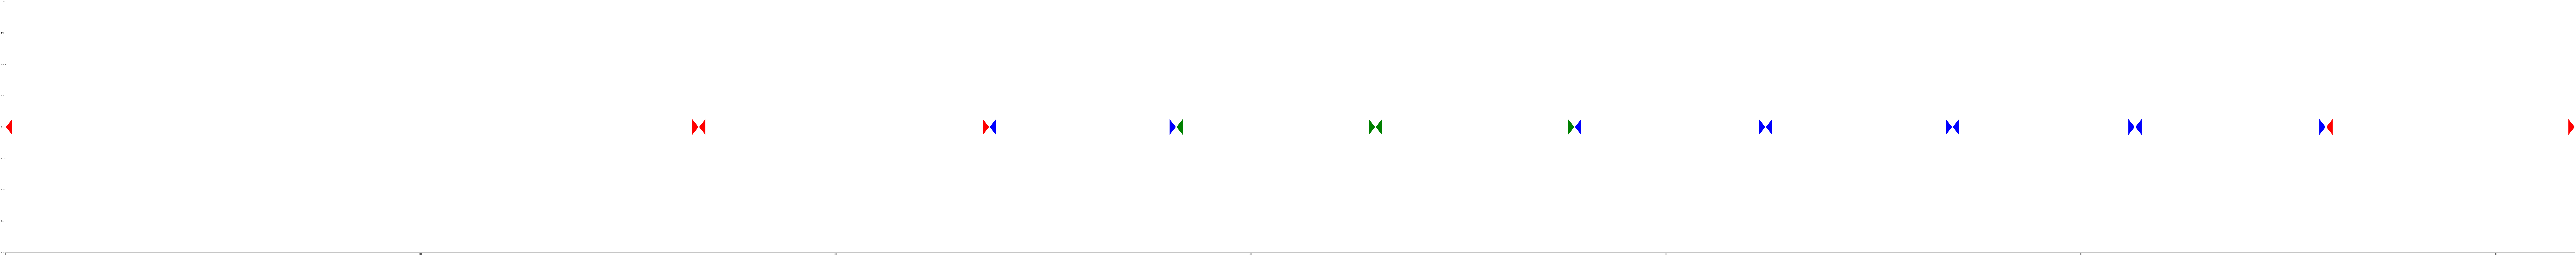

In [ ]:
#　サイクル間隔を描いたグラフを作成
from matplotlib.patches import ArrowStyle

def arrow():
    fig = plt.figure(figsize = (300, 30))
    ax = fig.add_subplot(111)
    # 矢印のグラフィック
    arrow_style_list = [
        ArrowStyle('<|-|>', head_length=4, head_width=5),
        ArrowStyle(']-[', lengthA=1.5, lengthB=0.5, widthA=1.5, widthB=0.5),
        ArrowStyle('|-|', widthA=1.5, widthB=0.5),
        ArrowStyle('fancy', head_length=3, head_width=3, tail_width=1),
        ArrowStyle('wedge', tail_width=1, shrink_factor=0.1)
    ]

    #範囲指定（ここをサイクル間隔にいじる９
    y = 1
    # 矢印の描画
    for i in range(len(between_flag)):
      x_start = between_flag[i][0]
      x_end = between_flag[i][1]
      x_time = x_end - x_start

      if(x_time > cycle_avetime+2):
        ax.annotate('', xy=(x_end, y), xytext=(x_start, y),
                      arrowprops=dict(arrowstyle=arrow_style_list[0],
                                          facecolor='red',
                                          edgecolor='red')
                      )          
      elif(x_time < cycle_avetime-2):
        ax.annotate('', xy=(x_end, y), xytext=(x_start, y),
                      arrowprops=dict(arrowstyle=arrow_style_list[0],
                                          facecolor='blue',
                                          edgecolor='blue')
                      ) 
      else:
        ax.annotate('', xy=(x_end, y), xytext=(x_start, y),
                      arrowprops=dict(arrowstyle=arrow_style_list[0],
                                          facecolor='green',
                                          edgecolor='green')
                      ) 

    ax.set_xlim([0, movie_sec])
    ax.set_ylim([0, 2])
    
    plt.show()


if __name__ == '__main__':
    arrow()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


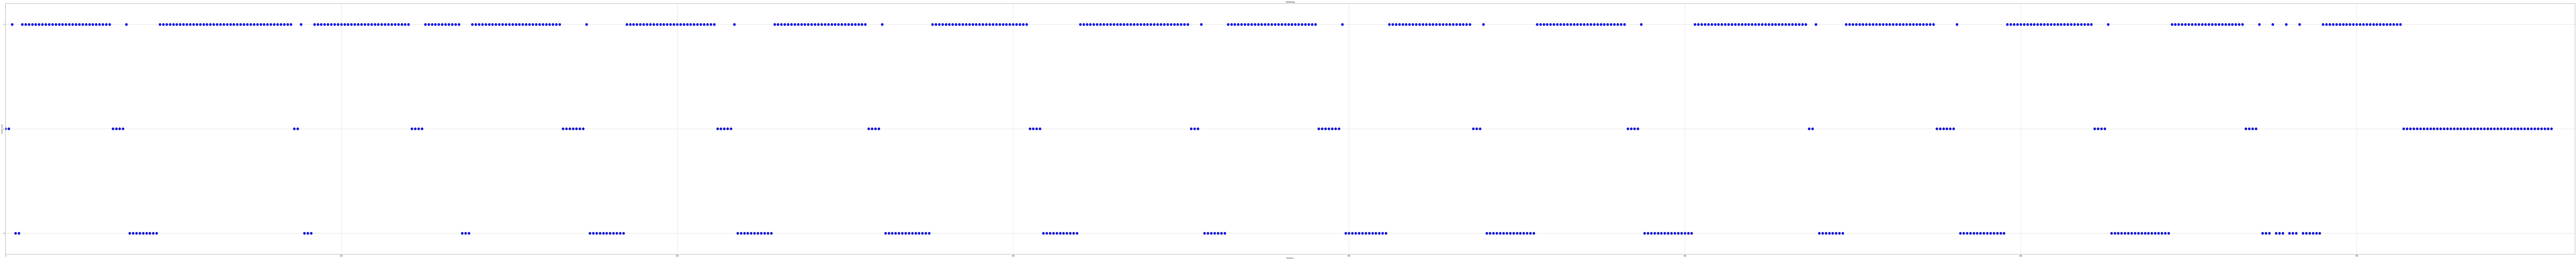

In [ ]:
#サブプロットで２つのグラフ合体できるはず・・・
#pythonグラフ作成セクション
plt.figure(figsize=(300,30))
fig.add_subplot(111)
plt.xlim(0, movie_sec) #x軸の表示範囲
plt.ylim(-0.2, 2.2) #y軸の表示範囲
plt.yticks([0, 1, 2])
plt.title("clustering")
plt.xlabel("time(sec)")
plt.ylabel("cluster_num")
plt.grid(True)
for i in sec:
  plt.scatter(i , excel_graphdata[i][2], s=250, c="b")

In [ ]:
workbook_name = "clustering"
#エクセルグラフ作成セクション
wb = openpyxl.load_workbook('/content/drive/MyDrive/Colab Notebooks/yolo/Yolov5_StrongSORT_OSNet/data/src/' + workbook_name + '.xlsx')
sheet = wb['Sheet1']

#配列ループ
for i in sec:
  #a列：秒数
  sheet.cell(i+4, 1, value = sec[i]+1)
  #b〜e列：場合分け
  if(excel_graphdata[i][2] == 0):
    sheet.cell(i+4, 2, value = 1)
  elif(excel_graphdata[i][2] == 1):
    sheet.cell(i+4, 3, value = 1)
  else:
    sheet.cell(i+4, 4, value = 1)

wb.save('/content/drive/MyDrive/Colab Notebooks/yolo/Yolov5_StrongSORT_OSNet/data/src/' + workbook_name + '.xlsx')

In [ ]:
#動画編集（動画に作業人数に応じた文字を出力）
import cv2
from PIL import Image, ImageFont, ImageDraw
import numpy as np
import os

In [ ]:
my_font_path = '/content/drive/MyDrive/Colab Notebooks/yolo/font/ipag.ttf'
my_position = (40, 40)

#関数定義
# 画像に文字を入れる関数
def telop(img, message, W, H):
    font_path =  my_font_path     # フォント指定
    font_size = 30                                   # フォントサイズ
    font = ImageFont.truetype(font_path, font_size)  # PILでフォントを定義
    img = Image.fromarray(img)                       # cv2(NumPy)型の画像をPIL型に変換
    draw = ImageDraw.Draw(img)                       # 描画用のDraw関数を用意

    w, h = draw.textsize(message, font)              # .textsizeで文字列のピクセルサイズを取得

    # テロップの位置positionは画像サイズと文字サイズから決定する
    # 横幅中央、縦は下
    #position = (int((W - w) / 2), int(H - (font_size * 1.5)))

    # 中央揃え
    #position = (int((W - w) / 2), int((H - h) / 2))
    position = my_position

    # テキストを描画（位置、文章、フォント、文字色(BGR+α)を指定）
    draw.text(position, message, font=font, fill=(255, 215, 0, 0))

    # PIL型の画像をcv2(NumPy)型に変換
    img = np.array(img)
    return img

# 動画を読み込み1フレームずつ画像処理をする関数
def m_slice(path, dir, step, message):
    in_path = os.path.join(*[dir, path])                # 読み込みパスを作成
    out_path = os.path.join(*[dir, 'out_' + path])      # 書き込みパスを作成
    movie = cv2.VideoCapture(in_path)                   # 動画の読み込み
    Fs = int(movie.get(cv2.CAP_PROP_FRAME_COUNT))       # 動画の全フレーム数を計算
    fps = movie.get(cv2.CAP_PROP_FPS)                   # 動画のFPS（フレームレート：フレーム毎秒）を取得
    W = int(movie.get(cv2.CAP_PROP_FRAME_WIDTH))        # 動画の横幅を取得
    H = int(movie.get(cv2.CAP_PROP_FRAME_HEIGHT))       # 動画の縦幅を取得
    fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v') # 動画保存時のfourcc設定（mp4用）

    # 動画の仕様（ファイル名、fourcc, FPS, サイズ）
    video = cv2.VideoWriter(out_path, fourcc, int(fps / step), (W, H))
    ext_index = np.arange(0, Fs, step)  # 動画から静止画（フレーム）を抽出する間隔

    j = 0                               # message配列から文章と時間を抜き出す指標番号
    section = message[j]                # フレームに書き込む文章と時間の初期値
    for i in range(Fs):                 # フレームサイズ分のループを回す
        print(i)
        flag, frame = movie.read()      # 動画から1フレーム読み込む
        check = i == ext_index          # 現在のフレーム番号iが、抽出する指標番号と一致するかチェックする
        time = i / int(fps/step)        # 抽出したフレームの動画内経過時間

        if flag == True: # フレームを取得できた時だけこの処理をする
            # もしi番目のフレームが静止画を抽出するものであれば、ファイル名を付けて保存する
            if True in check:
                # ここから動画フレーム処理と動画保存---------------------------------------------------------------------
                # 抽出したフレームの再生時間がテロップを入れる時間範囲に入っていれば文字入れする
                if section[1] <= time <= section[2]:
                    frame = telop(frame, section[0], W, H)  # テロップを入れる関数を実行
                # 再生時間がテロップ入れ開始時間より小さければ待機する
                elif section[1] > time:
                    pass
                else:
                    # 用意した文章がなくなったら何もしない
                    if j >= len(message) - 1:
                        pass
                    # 再生時間範囲になく、まだmessage配列にデータがある場合はjを増分しsectionを更新
                    else:
                        j = j + 1
                        section = message[j]
                video.write(frame)                          # 動画を1フレームずつ保存する
            # ここまでが動画フレーム処理と保存---------------------------------------------------------------------
            # i番目のフレームが静止画を抽出しないものであれば、何も処理をしない
            else:
                pass
        else:
            pass
    return

In [ ]:
#テキストを表示する条件設定(detect_nparrayが['time', 'trackingNo', 'x_normalized', 'y_normalized']を含んだ配列)
#まずは、timeをステップ数から秒数に変換
onesecond_step = 1/onestep_time #1秒あたりのステップ数

#全体のステップ数
start_step = detect_nparray[0][0]
end_step = detect_nparray[len(detect_nparray) - 1][0] 
movie_step = int(end_step - start_step + 1)

count = 0
start_one_sec = 0
start_two_sec = 0
start_other_sec = 0
end_one_sec = 0
end_two_sec = 0
end_other_sec = 0
flag_count = []
message = []

for i in range(movie_step):
  if i % int(onesecond_step) == start_step:
    print(str(count) + "秒")

    if len(np.where(detect_nparray[:, 0] == i)[0]) == 1:
      print("1人作業中")
      flag_count.append(1)
      if flag_count[count - 1] != 1:
        start_one_sec = count
        if flag_count[count - 1] == 2:
          end_two_sec = count
        if flag_count[count - 1] == 3:
          end_other_sec = count
        
    elif len(np.where(detect_nparray[:, 0] == i)[0]) == 2:
      print("2人作業中")
      flag_count.append(2)
      if flag_count[count - 1] != 2:
        start_two_sec = count
        if flag_count[count - 1] == 1:
          end_one_sec = count
        if flag_count[count - 1] == 3:
          end_other_sec = count
    else:
      print("3人以上もしくはだれも写っていません")
      flag_count.append(3)
      if flag_count[count - 1] != 3:
        start_other_sec = count
        if flag_count[count - 1] == 1:
          end_one_sec = count
        if flag_count[count - 1] == 2:
          end_two_sec = count

    if(end_one_sec):
      print("!!!一人作業が終了しました：　開始時刻： " + str(start_one_sec) + "終了時刻： " +  str(end_one_sec))
      message.append(['1人作業中', start_one_sec, end_one_sec])
    elif(end_two_sec):
      print("!!!二人作業が終了しました：　開始時刻： " + str(start_two_sec) + "終了時刻： " +  str(end_two_sec))
      message.append(['2人作業中', start_two_sec, end_two_sec])
    elif(end_other_sec):
      print("!!!三人作業が終了しました：　開始時刻： " + str(start_other_sec) + "終了時刻： " +  str(end_other_sec))
      message.append(['3人以上もしくはだれも写っていません', start_other_sec, end_other_sec])

    count += 1
    end_one_sec = 0
    end_two_sec = 0
    end_other_sec = 0

print(message)

0秒
2人作業中
1秒
2人作業中
2秒
2人作業中
3秒
2人作業中
4秒
1人作業中
!!!二人作業が終了しました：　開始時刻： 0終了時刻： 4
5秒
2人作業中
!!!一人作業が終了しました：　開始時刻： 4終了時刻： 5
6秒
1人作業中
!!!二人作業が終了しました：　開始時刻： 5終了時刻： 6
7秒
1人作業中
8秒
2人作業中
!!!一人作業が終了しました：　開始時刻： 6終了時刻： 8
9秒
2人作業中
10秒
2人作業中
11秒
2人作業中
12秒
2人作業中
13秒
2人作業中
14秒
2人作業中
15秒
2人作業中
16秒
2人作業中
17秒
2人作業中
18秒
2人作業中
19秒
2人作業中
20秒
2人作業中
21秒
2人作業中
22秒
2人作業中
23秒
2人作業中
24秒
2人作業中
25秒
2人作業中
26秒
3人以上もしくはだれも写っていません
!!!二人作業が終了しました：　開始時刻： 8終了時刻： 26
27秒
2人作業中
!!!三人作業が終了しました：　開始時刻： 26終了時刻： 27
28秒
1人作業中
!!!二人作業が終了しました：　開始時刻： 27終了時刻： 28
29秒
1人作業中
30秒
1人作業中
31秒
2人作業中
!!!一人作業が終了しました：　開始時刻： 28終了時刻： 31
32秒
2人作業中
33秒
1人作業中
!!!二人作業が終了しました：　開始時刻： 31終了時刻： 33
34秒
1人作業中
35秒
2人作業中
!!!一人作業が終了しました：　開始時刻： 33終了時刻： 35
36秒
1人作業中
!!!二人作業が終了しました：　開始時刻： 35終了時刻： 36
37秒
1人作業中
38秒
1人作業中
39秒
1人作業中
40秒
1人作業中
41秒
1人作業中
42秒
1人作業中
43秒
1人作業中
44秒
1人作業中
45秒
2人作業中
!!!一人作業が終了しました：　開始時刻： 36終了時刻： 45
46秒
1人作業中
!!!二人作業が終了しました：　開始時刻： 45終了時刻： 46
47秒
1人作業中
48秒
1人作業中
49秒
2人作業中
!!!一人作業が終了しました：　開始時刻： 46終了時刻： 49
50秒
2人作業中
51秒
2人作業中
52秒
2人作業中
53秒
2人作業中
54秒


In [ ]:
#パス設定
dir = '/content/drive/MyDrive/Colab Notebooks/yolo/Yolov5_StrongSORT_OSNet/runs/track/exp'               # 動画が保存されているディレクトリ
path = 'usually.mp4'   # ファイル名
step = 1                    # 動画内で処理するフレーム間隔（1より大きい整数だと動画が間引かれる）

# 動画処理の関数を実行
m_slice(path, dir, step, message)

ストリーミング出力は最後の 5000 行に切り捨てられました。
17952
17953
17954
17955
17956
17957
17958
17959
17960
17961
17962
17963
17964
17965
17966
17967
17968
17969
17970
17971
17972
17973
17974
17975
17976
17977
17978
17979
17980
17981
17982
17983
17984
17985
17986
17987
17988
17989
17990
17991
17992
17993
17994
17995
17996
17997
17998
17999
18000
18001
18002
18003
18004
18005
18006
18007
18008
18009
18010
18011
18012
18013
18014
18015
18016
18017
18018
18019
18020
18021
18022
18023
18024
18025
18026
18027
18028
18029
18030
18031
18032
18033
18034
18035
18036
18037
18038
18039
18040
18041
18042
18043
18044
18045
18046
18047
18048
18049
18050
18051
18052
18053
18054
18055
18056
18057
18058
18059
18060
18061
18062
18063
18064
18065
18066
18067
18068
18069
18070
18071
18072
18073
18074
18075
18076
18077
18078
18079
18080
18081
18082
18083
18084
18085
18086
18087
18088
18089
18090
18091
18092
18093
18094
18095
18096
18097
18098
18099
18100
18101
18102
18103
18104
18105
18106
18107
18108
18109
18110
18111
18112
18